<a href="https://colab.research.google.com/github/zukol/dw_matrix_road_sign/blob/master/dw_matrix3_day4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [63]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import os
import datetime

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Conv1D, MaxPool2D, Dense, Flatten, Dropout
from tensorflow.keras.utils import to_categorical
from skimage import color, exposure
from sklearn.metrics import accuracy_score

%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [64]:
cd '/content/drive/My Drive/Colab Notebooks/matrix/matrix_three/data'

/content/drive/My Drive/Colab Notebooks/matrix/matrix_three/data


In [65]:
ls

logs/  signnames.csv  test.p  train.p


In [0]:
train = pd.read_pickle('train.p')
test = pd.read_pickle('test.p')

X_train, y_train = train['features'], train['labels']
X_test, y_test = test['features'], test['labels']

In [67]:
y_train

array([41, 41, 41, ..., 25, 25, 25], dtype=uint8)

In [68]:
len(np.unique(y_train))

43

In [0]:
if y_train.ndim == 1:
  y_train = to_categorical(y_train)

if y_test.ndim == 1:
  y_test = to_categorical(y_test)

In [70]:
y_train.shape

(34799, 43)

In [0]:
input_shape = X_train.shape[1:]
num_calsses = y_train.shape[1]

In [0]:
model = Sequential([
    Conv2D(filters=64, kernel_size=(3, 3), activation='relu', input_shape=input_shape),
    Flatten(),
    Dense(num_calsses, activation='softmax')
])
#model.summary()
model.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=['accuracy'])

In [73]:
model.fit(X_train, y_train)

1088/1088 [==============================] - 4s 4ms/step - loss: 12.9169 - accuracy: 0.7673


In [0]:
def get_cnn_v1(input_shape, num_calsses):
  return Sequential([
    Conv2D(filters=64, kernel_size=(3, 3), activation='relu', input_shape=input_shape),
    Flatten(),
    Dense(num_calsses, activation='softmax')
])
  
logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)

def train_model(model, X_train, y_train, params_fit={}):
  model.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=['accuracy'])
  model.fit(X_train,
            y_train,
            batch_size = params_fit.get('batch_size', 128),
            epochs = params_fit.get('epochs', 5),
            verbose = params_fit.get('verbose', 1),
            validation_data = params_fit.get('validation_data', (X_train, y_train)),
            callbacks = [tensorboard_callback])
  return model

In [75]:
model = get_cnn_v1(input_shape, num_calsses)
model_trained = train_model(model, X_train, y_train)

Epoch 1/5
272/272 [==============================] - 3s 12ms/step - loss: 30.3641 - accuracy: 0.7264 - val_loss: 0.2880 - val_accuracy: 0.9353
Epoch 2/5
272/272 [==============================] - 3s 11ms/step - loss: 0.2553 - accuracy: 0.9433 - val_loss: 0.1611 - val_accuracy: 0.9590
Epoch 3/5
272/272 [==============================] - 3s 11ms/step - loss: 0.1533 - accuracy: 0.9649 - val_loss: 0.0994 - val_accuracy: 0.9741
Epoch 4/5
272/272 [==============================] - 3s 11ms/step - loss: 0.1524 - accuracy: 0.9669 - val_loss: 0.0700 - val_accuracy: 0.9843
Epoch 5/5
272/272 [==============================] - 3s 11ms/step - loss: 0.0885 - accuracy: 0.9802 - val_loss: 0.0952 - val_accuracy: 0.9792


In [0]:
def predict(model_trained, X_test, y_test, scoring=accuracy_score):

  y_test_norm = np.argmax(y_test, axis=1)

  y_pred_prob = model_trained.predict(X_test)
  y_pred = np.argmax(y_pred_prob, axis=1)

  return scoring(y_test_norm, y_pred)

In [77]:
predict(model_trained, X_test, y_test)

0.8115646258503402

In [0]:
def train_and_predict(model):
  model_trained = train_model(model, X_train, y_train)
  return predict(model_trained, X_test, y_test)

In [44]:
def get_cnn_v2(input_shape, num_calsses):
  return Sequential([
    Conv2D(filters=32, kernel_size=(3, 3), activation='relu', input_shape=input_shape),
    MaxPool2D(),
    Dropout(0.3),

    Conv2D(filters=64, kernel_size=(3, 3), activation='relu'),
    MaxPool2D(),
    Dropout(0.3),

    Flatten(),

    Dense(1024, activation='relu'),
    Dropout(0.3),

    Dense(num_calsses, activation='softmax')
])

train_and_predict(get_cnn_v2(input_shape, num_calsses))

Epoch 1/5
272/272 [==============================] - 3s 12ms/step - loss: 8.9701 - accuracy: 0.1581 - val_loss: 2.5059 - val_accuracy: 0.3144
Epoch 2/5
272/272 [==============================] - 3s 10ms/step - loss: 2.0204 - accuracy: 0.4211 - val_loss: 1.1627 - val_accuracy: 0.6823
Epoch 3/5
272/272 [==============================] - 3s 11ms/step - loss: 1.3098 - accuracy: 0.6061 - val_loss: 0.6760 - val_accuracy: 0.8263
Epoch 4/5
272/272 [==============================] - 3s 10ms/step - loss: 0.9148 - accuracy: 0.7216 - val_loss: 0.3979 - val_accuracy: 0.9073
Epoch 5/5
272/272 [==============================] - 3s 11ms/step - loss: 0.6187 - accuracy: 0.8092 - val_loss: 0.1841 - val_accuracy: 0.9516


0.8453514739229024

In [45]:
def get_cnn_v3(input_shape, num_calsses):
  return Sequential([
    Conv2D(filters=32, kernel_size=(3, 3), activation='relu', input_shape=input_shape),
    Conv2D(filters=32, kernel_size=(3, 3), activation='relu'),
    MaxPool2D(),
    Dropout(0.3),

    Conv2D(filters=64, kernel_size=(3, 3), activation='relu'),
    Conv2D(filters=64, kernel_size=(3, 3), activation='relu'),
    MaxPool2D(),
    Dropout(0.3),

    Flatten(),

    Dense(1024, activation='relu'),
    Dropout(0.3),

    Dense(num_calsses, activation='softmax')
])

train_and_predict(get_cnn_v3(input_shape, num_calsses))

Epoch 1/5
272/272 [==============================] - 4s 16ms/step - loss: 2.5553 - accuracy: 0.4352 - val_loss: 0.5730 - val_accuracy: 0.8684
Epoch 2/5
272/272 [==============================] - 4s 15ms/step - loss: 0.6889 - accuracy: 0.8030 - val_loss: 0.1513 - val_accuracy: 0.9661
Epoch 3/5
272/272 [==============================] - 4s 15ms/step - loss: 0.3091 - accuracy: 0.9108 - val_loss: 0.0782 - val_accuracy: 0.9818
Epoch 4/5
272/272 [==============================] - 4s 15ms/step - loss: 0.1936 - accuracy: 0.9428 - val_loss: 0.0368 - val_accuracy: 0.9921
Epoch 5/5
272/272 [==============================] - 4s 15ms/step - loss: 0.1455 - accuracy: 0.9570 - val_loss: 0.0227 - val_accuracy: 0.9949


0.9607709750566893

In [47]:
def get_cnn_v4(input_shape, num_calsses):
  return Sequential([
    Conv2D(filters=32, kernel_size=(3, 3), activation='relu', input_shape=input_shape),
    Conv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='same'),
    MaxPool2D(),
    Dropout(0.3),

    Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same'),
    Conv2D(filters=64, kernel_size=(3, 3), activation='relu'),
    MaxPool2D(),
    Dropout(0.3),

    Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same'),
    Conv2D(filters=64, kernel_size=(3, 3), activation='relu'),
    MaxPool2D(),
    Dropout(0.3),

    Flatten(),

    Dense(1024, activation='relu'),
    Dropout(0.3),

    Dense(num_calsses, activation='softmax')
])

#get_cnn_v4(input_shape, num_calsses).summary()
train_and_predict(get_cnn_v4(input_shape, num_calsses))

Epoch 1/5
272/272 [==============================] - 5s 18ms/step - loss: 2.8520 - accuracy: 0.2575 - val_loss: 1.1894 - val_accuracy: 0.6851
Epoch 2/5
272/272 [==============================] - 5s 17ms/step - loss: 0.8791 - accuracy: 0.7324 - val_loss: 0.2147 - val_accuracy: 0.9434
Epoch 3/5
272/272 [==============================] - 5s 17ms/step - loss: 0.3886 - accuracy: 0.8834 - val_loss: 0.1114 - val_accuracy: 0.9686
Epoch 4/5
272/272 [==============================] - 5s 17ms/step - loss: 0.2537 - accuracy: 0.9240 - val_loss: 0.0681 - val_accuracy: 0.9809
Epoch 5/5
272/272 [==============================] - 5s 17ms/step - loss: 0.1906 - accuracy: 0.9412 - val_loss: 0.0440 - val_accuracy: 0.9879


0.964625850340136

In [85]:
def get_cnn_v5(input_shape, num_calsses):
  return Sequential([
    Conv2D(filters=32, kernel_size=(3, 3), activation='relu', input_shape=input_shape),
    Conv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='same'),
    MaxPool2D(),
    Dropout(0.3),

    Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same'),
    Conv2D(filters=64, kernel_size=(3, 3), activation='relu'),
    MaxPool2D(),
    Dropout(0.3),

    Conv2D(filters=128, kernel_size=(3, 3), activation='relu', padding='same'),
    Conv2D(filters=128, kernel_size=(3, 3), activation='relu'),
    MaxPool2D(),
    Dropout(0.3),

    Flatten(),

    Dense(1024, activation='relu'),
    Dropout(0.3),

    Dense(1024, activation='relu'),
    Dropout(0.3),

    Dense(num_calsses, activation='softmax')
])

#get_cnn_v4(input_shape, num_calsses).summary()
train_and_predict(get_cnn_v5(input_shape, num_calsses))

Epoch 1/5
272/272 [==============================] - 5s 20ms/step - loss: 2.6248 - accuracy: 0.2727 - val_loss: 1.1463 - val_accuracy: 0.6633
Epoch 2/5
272/272 [==============================] - 5s 19ms/step - loss: 0.8249 - accuracy: 0.7382 - val_loss: 0.2134 - val_accuracy: 0.9345
Epoch 3/5
272/272 [==============================] - 5s 19ms/step - loss: 0.3440 - accuracy: 0.8958 - val_loss: 0.0660 - val_accuracy: 0.9808
Epoch 4/5
272/272 [==============================] - 5s 18ms/step - loss: 0.2116 - accuracy: 0.9363 - val_loss: 0.0490 - val_accuracy: 0.9853
Epoch 5/5
272/272 [==============================] - 5s 19ms/step - loss: 0.1599 - accuracy: 0.9538 - val_loss: 0.0387 - val_accuracy: 0.9899


0.9739229024943311

RGB to grey, 3 to 1 channel

In [79]:
X_train[0].shape

(32, 32, 3)

In [80]:
color.rgb2gray(X_train[0]).shape

(32, 32)

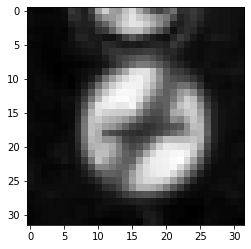

In [81]:
plt.imshow(color.rgb2gray(X_train[0]), cmap=plt.get_cmap('gray'))

In [0]:
#all
X_train_gray = color.rgb2gray(X_train).reshape(-1, 32, 32, 1)
X_test_gray = color.rgb2gray(X_test).reshape(-1, 32, 32, 1)

In [86]:
model = get_cnn_v5((32, 32, 1), num_calsses)
model_trained = train_model(model, X_train_gray, y_train, params_fit={})
predict(model_trained, X_test_gray, y_test)



Epoch 1/5
272/272 [==============================] - 5s 19ms/step - loss: 2.3324 - accuracy: 0.3302 - val_loss: 0.6242 - val_accuracy: 0.8054
Epoch 2/5
272/272 [==============================] - 5s 19ms/step - loss: 0.5237 - accuracy: 0.8282 - val_loss: 0.1087 - val_accuracy: 0.9706
Epoch 3/5
272/272 [==============================] - 5s 19ms/step - loss: 0.2150 - accuracy: 0.9345 - val_loss: 0.0489 - val_accuracy: 0.9866
Epoch 4/5
272/272 [==============================] - 5s 19ms/step - loss: 0.1397 - accuracy: 0.9565 - val_loss: 0.0275 - val_accuracy: 0.9930
Epoch 5/5
272/272 [==============================] - 5s 19ms/step - loss: 0.1047 - accuracy: 0.9659 - val_loss: 0.0161 - val_accuracy: 0.9959


0.972108843537415

In [27]:
y_pred_prob[400]

array([3.06404659e-11, 9.98750091e-01, 1.16598862e-14, 1.26112196e-17,
       1.24992838e-03, 4.74025938e-15, 2.06906538e-15, 3.60068421e-24,
       7.92642073e-24, 2.76902186e-15, 1.35234816e-22, 6.39343163e-22,
       2.37392562e-29, 4.42503470e-31, 3.26726458e-37, 1.28087155e-36,
       2.82875836e-29, 0.00000000e+00, 2.07884255e-24, 0.00000000e+00,
       4.18152352e-31, 1.31164115e-37, 0.00000000e+00, 5.17105016e-35,
       2.47983731e-36, 3.78444609e-36, 8.09980610e-36, 0.00000000e+00,
       5.70737200e-19, 2.68777396e-29, 0.00000000e+00, 5.23203809e-30,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 2.54239655e-35,
       0.00000000e+00, 0.00000000e+00, 1.54033005e-36, 0.00000000e+00,
       6.24031242e-34, 1.86047695e-34, 3.59322791e-27], dtype=float32)

In [0]:
df = pd.read_csv('signnames.csv')
labels_dict = df.to_dict()['b']

In [34]:
labels_dict [np.argmax(y_pred_prob[300])]

'Speed limit (30km/h)'

<BarContainer object of 43 artists>

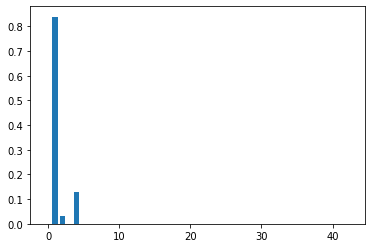

In [35]:
plt.bar(range(43), y_pred_prob[300])

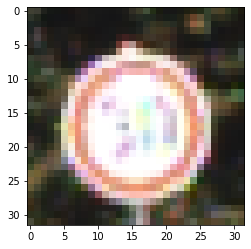

In [33]:
plt.imshow(X_test[300])

In [0]:
%tensorboard --logdir logs